In [273]:
import big_data_funs as bd
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from pathlib import Path
import numpy as np
reload(bd);


In [62]:
folder = "resultados_validos"

In [63]:
df_planets = bd.cargar_datos(folder)        
print(df_planets.tail())



    target planet_name    period  r_star  m_star  radius       a  from  \
268    Sun     Neptuno  598000.0     1.0     1.0   3.880  30.180  NASA   
269    Sun     Saturno   10747.0     1.0     1.0   9.450   9.570  NASA   
270    Sun      Tierra     365.2     1.0     1.0   1.000   1.000  NASA   
271    Sun       Urano   30895.0     1.0     1.0   4.010  19.170  NASA   
272    Sun       Venus     224.7     1.0     1.0   0.949   0.723  NASA   

    NEA_pl_name NEA_st_host  ...  NEA_a_au  NEA_a_au_err1  NEA_a_au_err2  \
268     Neptuno         Sun  ...    30.180            NaN            NaN   
269     Saturno         Sun  ...     9.570            NaN            NaN   
270      Tierra         Sun  ...     1.000            NaN            NaN   
271       Urano         Sun  ...    19.170            NaN            NaN   
272       Venus         Sun  ...     0.723            NaN            NaN   

     NEA_pl_rad_e:  NEA_pl_rad_e_err1  NEA_pl_rad_e_err2  NEA_pl_mass  \
268            NaN       

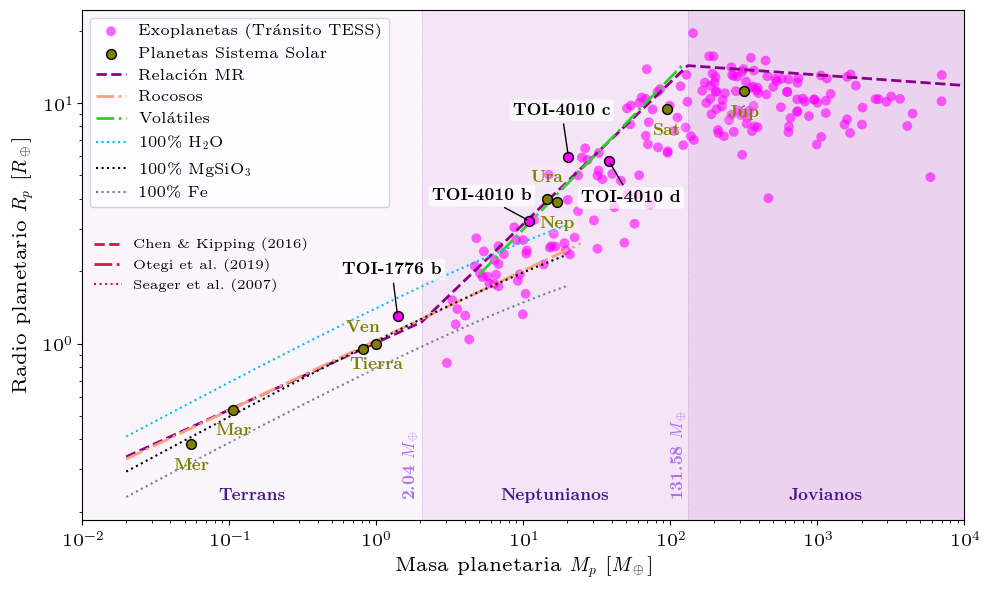

In [272]:
my_highlights = {
    'TOI-4010 c': 'TOI-4010 c', 
    'TOI-4010 d': 'TOI-4010 d',
    'TOI-4010 b': 'TOI-4010 b',
    '': '',
    'TOI-1776 b': 'TOI-1776 b',
}


def get_mass_radius_lines():
    m = np.logspace(np.log10(0.02), np.log10(20000), 700)

    M_jup = 317.83
    M_sun = 332946

    # chen - kipping (tabla 1)
    
    # La ley de potencia que sigue la distribución es: R = C * M**s, con R y M expresadas en unidades terrestres,
    # C y s variando en función de M.

    M_split1 = 2.04  #terran --> nept
    M_split2 = 0.414 * M_jup #nept --> jovian
    M_split3 = 0.080 * M_sun #jovian --> stellar     

    # Omito los errores
    s_ter = 0.279
    s_nep = 0.589
    s_jov = -0.044
    s_stl = 0.881
    
    C_ter = 1.008 
    
    R_split1 = C_ter * (M_split1 ** s_ter)
    C_nep = R_split1 / (M_split1 ** s_nep)
    
    R_split2 = C_nep * (M_split2 ** s_nep)
    C_jov = R_split2 / (M_split2 ** s_jov)

    R_split3 = C_jov * (M_split3 ** s_jov)
    C_stl = R_split3 / (M_split3 ** s_stl)
    
    r_values = np.zeros_like(m)
    
    mask_ter = m < M_split1
    mask_nep = (m >= M_split1) & (m < M_split2)
    mask_jov = (m >= M_split2) & (m < M_split3)
    mask_stl = m > M_split3    
    
    r_values[mask_ter] = C_ter * (m[mask_ter] ** s_ter)
    r_values[mask_nep] = C_nep * (m[mask_nep] ** s_nep)
    r_values[mask_jov] = C_jov * (m[mask_jov] ** s_jov)
    r_values[mask_stl] = C_stl * (m[mask_stl] ** s_stl)

    lines = [{'x': m, 'y': r_values, 'color': 'darkmagenta', 'linestyle': '--', 'lw': 2, 'label': 'Relación MR'}]

    zones = [
            (1e-2, M_split1, '#F3E5F5', r'Terrans'),      
            (M_split1, M_split2, '#E1BEE7', r'Neptunianos'),     
            (M_split2, 1e4, '#CE93D8', r'Jovianos')       
            ]

    # otegi (ecuación 1)

    mask_ote_roc = m < 25
    mask_ote_vol = (m > 5) & (m < 120)
    
    r_otegi_roc = 1.03 * m[mask_ote_roc]**0.29
    r_otegi_vol = 0.70 * m[mask_ote_vol]**0.63

    lines.append({'x': m[mask_ote_roc], 'y': r_otegi_roc, 'color': 'lightsalmon', 'linestyle': '-.', 'lw': 2, 'label': 'Rocosos', 'zorder':11, 'alpha':0.5})
    lines.append({'x': m[mask_ote_vol], 'y': r_otegi_vol, 'color': 'limegreen', 'linestyle': '-.', 'lw': 2, 'label': 'Volátiles', 'zorder':11, 'alpha':0.5})


    #linea agua pura - seager (tabla 4 + ec. 23: log10(Rs) = k1 + 1/3*log10(Ms) - k2*Ms^k3)
    mask_EOS = m < 20


    
    # ice (agua pura)
    m1_ice = 5.52
    r1_ice = 4.43
    k_ice = [-0.209396, 0.0807, 0.375]

    
    m_s_ice = m[mask_EOS] / m1_ice
    log_rs = k_ice[0] + (1/3)*np.log10(m_s_ice) - k_ice[1] * m_s_ice**k_ice[2]
    r_ice = (10**log_rs) * r1_ice
    
    lines.append({
        'x': m[mask_EOS], 'y': r_ice, 'color': 'deepskyblue', 'linestyle': ':', 'lw': 1.5, 'label': r'100% H$_2$O'
    })


        
    # perovskita
    m1_per = 10.55
    r1_per = 3.90
    k_per = [-0.209594, 0.0799, 0.413]

    
    m_s_per = m[mask_EOS] / m1_per
    log_rs_per = k_per[0] + (1/3)*np.log10(m_s_per) - k_per[1] * m_s_per**k_per[2]
    r_per = (10**log_rs_per) * r1_per
    
    lines.append({
        'x': m[mask_EOS], 'y': r_per, 'color': 'k', 'linestyle': ':', 'lw': 1.5, 'label': r'100% MgSiO$_3$'
    })


    # fe (hierro pura)
    m1_fe = 5.80
    r1_fe = 2.52
    k_fe = [-0.209490, 0.0804, 0.394]

    
    m_s_fe = m[mask_EOS] / m1_fe
    log_rs_fe = k_fe[0] + (1/3)*np.log10(m_s_fe) - k_fe[1] * m_s_fe**k_fe[2]
    r_fe = (10**log_rs_fe) * r1_fe
    
    lines.append({
        'x': m[mask_EOS], 'y': r_fe, 'color': 'slategrey', 'linestyle': ':', 'lw': 1.5, 'label': '100% Fe'
    })

    
    return lines, zones
    
leg_ref = [
    Line2D([0], [0], color='crimson', ls='--', lw=2,
           label='Chen & Kipping (2016)'),
    Line2D([0], [0], color='crimson', ls='-.', lw=2,
           label='Otegi et al. (2019)'),
    Line2D([0], [0], color='crimson', ls=':', lw=1.5,
           label='Seager et al. (2007)')
]

lines_MR, zones = get_mass_radius_lines()

bd.plot_y_vs_x(df_planets, "radius", "NEA_pl_mass",
                x_label=r'Masa planetaria $M_p$ [$M_\oplus$]', y_label=r'Radio planetario $R_p$ [$R_\oplus$]',
                y_log=True, x_log=True, grid = False, lines = lines_MR,  bckg_zones = zones,
                highlight_names=my_highlights, save_path = 'Diagrama MR', leg_ref = leg_ref)




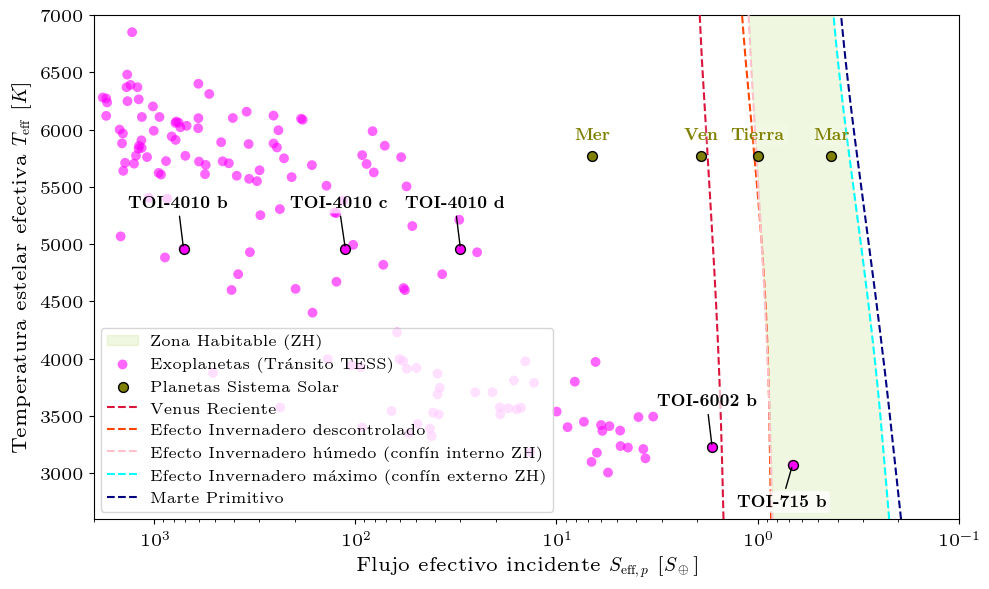

In [274]:
my_highlights = {
    'TOI-4010 c': 'TOI-4010 c',
    '':'',
    'TOI-4010 b': 'TOI-4010 b',
    '':'',
    'TOI-1776 b': 'TOI-1776 b',
    'TOI-4010 d': 'TOI-4010 d',
    '': '',
    'TOI-715 b': 'TOI-715 b',
    '': '',
    '': '',
    'TOI-6002 b': 'TOI-6002 b'
}


t_eff = np.linspace(2600, 7200, 300) #rango de T_eff en el que el modelo de kopp es aplicable

def get_hz_lines(t_eff):
    t_star = t_eff - 5780  #delta T respecto al Sol
    
    def calc_seff(t, coeffs):
        '''
        t = T⋆ = Tef f − 5780 K
        '''
        return coeffs[0] + coeffs[1]*t + coeffs[2]*t**2 + coeffs[3]*t**3 + coeffs[4]*t**4

    # Coeficientes de tabla 3 kopp. (del paper del ERRATUM)

    # recent venus
    c_rv = [1.7753, 1.4335e-4, 3.3954e-9, -7.6364e-12, -1.1950e-15] 
    # runaway greenhouse
    c_rg = [1.0385, 1.2456e-4, 1.4612e-8, -7.6345e-12, -1.7511e-15]
    # moist greenhouse
    c_mg = [1.0146, 8.1884e-5, 1.9394e-9, -4.3618e-12, -6.8260e-16]
    # Maximum greenhouse
    c_Mg = [0.3507, 5.9578e-5, 1.6707e-9, -3.0058e-12, -5.1925e-16]
    # early mars
    c_em = [0.3207, 5.4471e-5, 1.5275e-9, -2.1709e-12, -3.8282e-16]

    s_rv = calc_seff(t_star, c_rv)
    s_rg = calc_seff(t_star, c_rg)
    s_mg = calc_seff(t_star, c_mg)
    s_Mg = calc_seff(t_star, c_Mg)
    s_em = calc_seff(t_star, c_em)
    
    return (
        [
        {'x': s_rv, 'y': t_eff, 'color': 'crimson', 'linestyle': '--', 'lw': 1.5, 'label': 'Venus Reciente'},
        {'x': s_rg, 'y': t_eff, 'color': 'orangered', 'linestyle': '--', 'lw': 1.5, 'label': 'Efecto Invernadero descontrolado'},
        {'x': s_mg, 'y': t_eff, 'color': 'pink', 'linestyle': '--', 'lw': 1.5, 'label': 'Efecto Invernadero húmedo (confín interno ZH)'},
        {'x': s_Mg, 'y': t_eff, 'color': 'cyan', 'linestyle': '--', 'lw': 1.5, r'label': 'Efecto Invernadero máximo (confín externo ZH)'},
        {'x': s_em, 'y': t_eff, 'color': 'navy', 'linestyle': '--', 'lw': 1.5, 'label': 'Marte Primitivo'}
    ],
        s_mg, s_Mg
        
    )
lines_hz, s_mg, s_Mg = get_hz_lines(t_eff)
hz_data = (t_eff, s_mg, s_Mg)


bd.plot_y_vs_x(df_planets, "NEA_st_Teff", "NEA_ins_flux",
                y_label=r'Temperatura estelar efectiva $T_\mathrm{eff}$ [$K$]', x_label=r'Flujo efectivo incidente $S_{\text{eff},p}$ [$S_\oplus$]', 
                y_log=False, x_log=True, grid = False, lines = lines_hz, hz_data = hz_data,
                highlight_names=my_highlights, x_lim_d =1e-1, x_lim_u = 2e3, y_lim_d = 2600, y_lim_u = 7000, loc = 'lower left', inv_xaxis =True, save_path = 'Zona Habitable')



In [74]:
new_earth = df_planets[
    (df_planets["NEA_st_Teff"] < 3500) &  (df_planets["NEA_st_Teff"] > 3000) &
    (df_planets["NEA_ins_flux"] < 2 )
]
print('Nuevas Tierras')
print(new_earth)

only_roc = df_planets[(df_planets['NEA_pl_mass'] < 2.04) & (df_planets['target'] != 'Sun') ]
print('Únicos rocosos')
print(only_roc)




Nuevas Tierras
       target planet_name     period    r_star    m_star    radius         a  \
231  TOI-6002  TOI-6002 b  10.904914  0.242121  0.212382  1.548420  0.057419   
250   TOI-715   TOI-715 b  19.287853  0.229824  0.199363  1.613749  0.082225   

               from NEA_pl_name NEA_st_host  ...  NEA_a_au  NEA_a_au_err1  \
231  Transit (TESS)  TOI-6002 b    TOI-6002  ...   0.05722        0.00044   
250  Transit (TESS)   TOI-715 b     TOI-715  ...   0.08300        0.00270   

     NEA_a_au_err2  NEA_pl_rad_e:  NEA_pl_rad_e_err1  NEA_pl_rad_e_err2  \
231        0.00044           1.65              0.220             -0.190   
250        0.00270           1.55              0.064             -0.064   

     NEA_pl_mass  NEA_ins_flux  NEA_pl_eq_temp  NEA_pl_rad_e  
231          NaN        1.6823           321.4           NaN  
250          NaN        0.6700           234.0           NaN  

[2 rows x 26 columns]
Únicos rocosos
      target planet_name    period    r_star  m_star    rad

A PARTIR DE AQUÍ NO LO USO (FULTON GAP + Otras Gráficas)

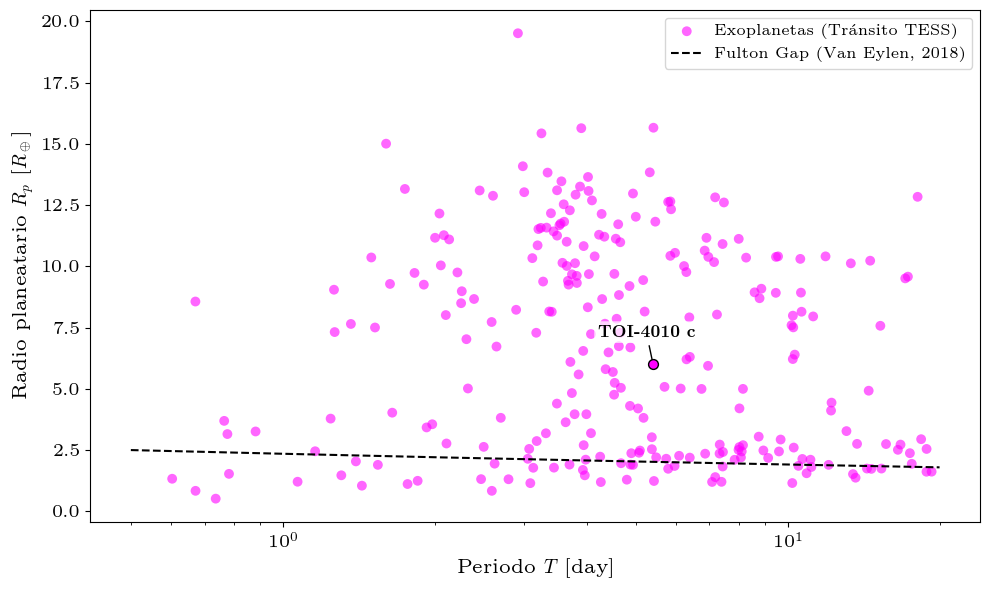

In [152]:
def get_radius_period_lines():
    p = np.linspace(0.5, 20, 200)
    
    # Van Eylen 2018
    slope = -0.09
    intercept = 0.37
    
    r_valley = 10**(slope * np.log10(p) + intercept)
    
    return [
        {'x': p, 'y': r_valley, 'color': 'black', 'linestyle': '--', 'lw': 1.5, 'label': 'Fulton Gap (Van Eylen, 2018)'}
    ]


lines_rp = get_radius_period_lines()
    
bd.plot_y_vs_x(df_planets, "radius", "period", lines = lines_rp,
               y_label=r'Radio planeatario $R_p$ [$R_\oplus$]',x_label=r'Periodo $T$ [day]',
               y_log=False, x_log=True, 
                grid = False, 
              highlight_names=my_highlights)






In [33]:
# bd.plot_y_vs_x(df_planets, "NEA_pl_mass", "radius", y_den ="radius",
#                 y_label=r'Densidad planetaria $\rho_p$ [$M_\oplus \cdot R_\oplus^{-3}$]', x_label=r'Radio planetario $R_p$ [$R_\oplus$]',
#                 y_log=True, x_log=True, grid = False,
#                 highlight_names=my_highlights)


# bd.plot_y_vs_x(df_planets, "NEA_pl_mass", "NEA_pl_mass", y_den ="radius",
#                 y_label=r'Densidad planetaria $\rho_p$ [$M_\oplus \cdot R_\oplus^{-3}$]', x_label=r'Radio plnetario $R_p$ [$R_\oplus$]', 
#                 y_log=True, x_log=True, grid = False,
#                 highlight_names=my_highlights)

# bd.plot_y_vs_x(df_planets, "NEA_pl_mass", "period",
#                 y_label=r'Masa planeataria $M_p$ [$M_\oplus$]', x_label=r'Period T [days]',
#                 highlight_names=my_highlights)




# bd.plot_y_vs_x(df_planets, "NEA_pl_mass", "a",
#                y_label=r'Radio planeatario $R_p$ [$R_\oplus$]',x_label=r'Semieje mayor $a$ [AU]',
#                y_log=True, x_log=True, 
#                 grid = False, 
#               highlight_names=my_highlights)

# bd.plot_y_vs_x(df_planets, "NEA_st_Teff", "radius",
#                 y_label=r'Temperatura estelar efectiva $T_\mathrm{eff}$ [$K$]', x_label=r'Radio planetario $R_p$ [$R_\oplus$]', 
#                 y_log=False, x_log=True, grid = False,
#                 highlight_names=my_highlights)
